**IMPORT LIBRARIES**

In [5]:
import os
import cv2
import random
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

from moviepy.editor import *

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
# setting up numpy, python and tensorflow seeds to get consitent results on every execution
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

**STEP 1: DOWNLOAD AND VISUALIZE THE DATA WITH ITS LABELS**

In [7]:
# Downloading and extracting dataset

# discard the output of this cell
%%capture

# Download the dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# Extract the dataset
!unrar x UCF50.rar

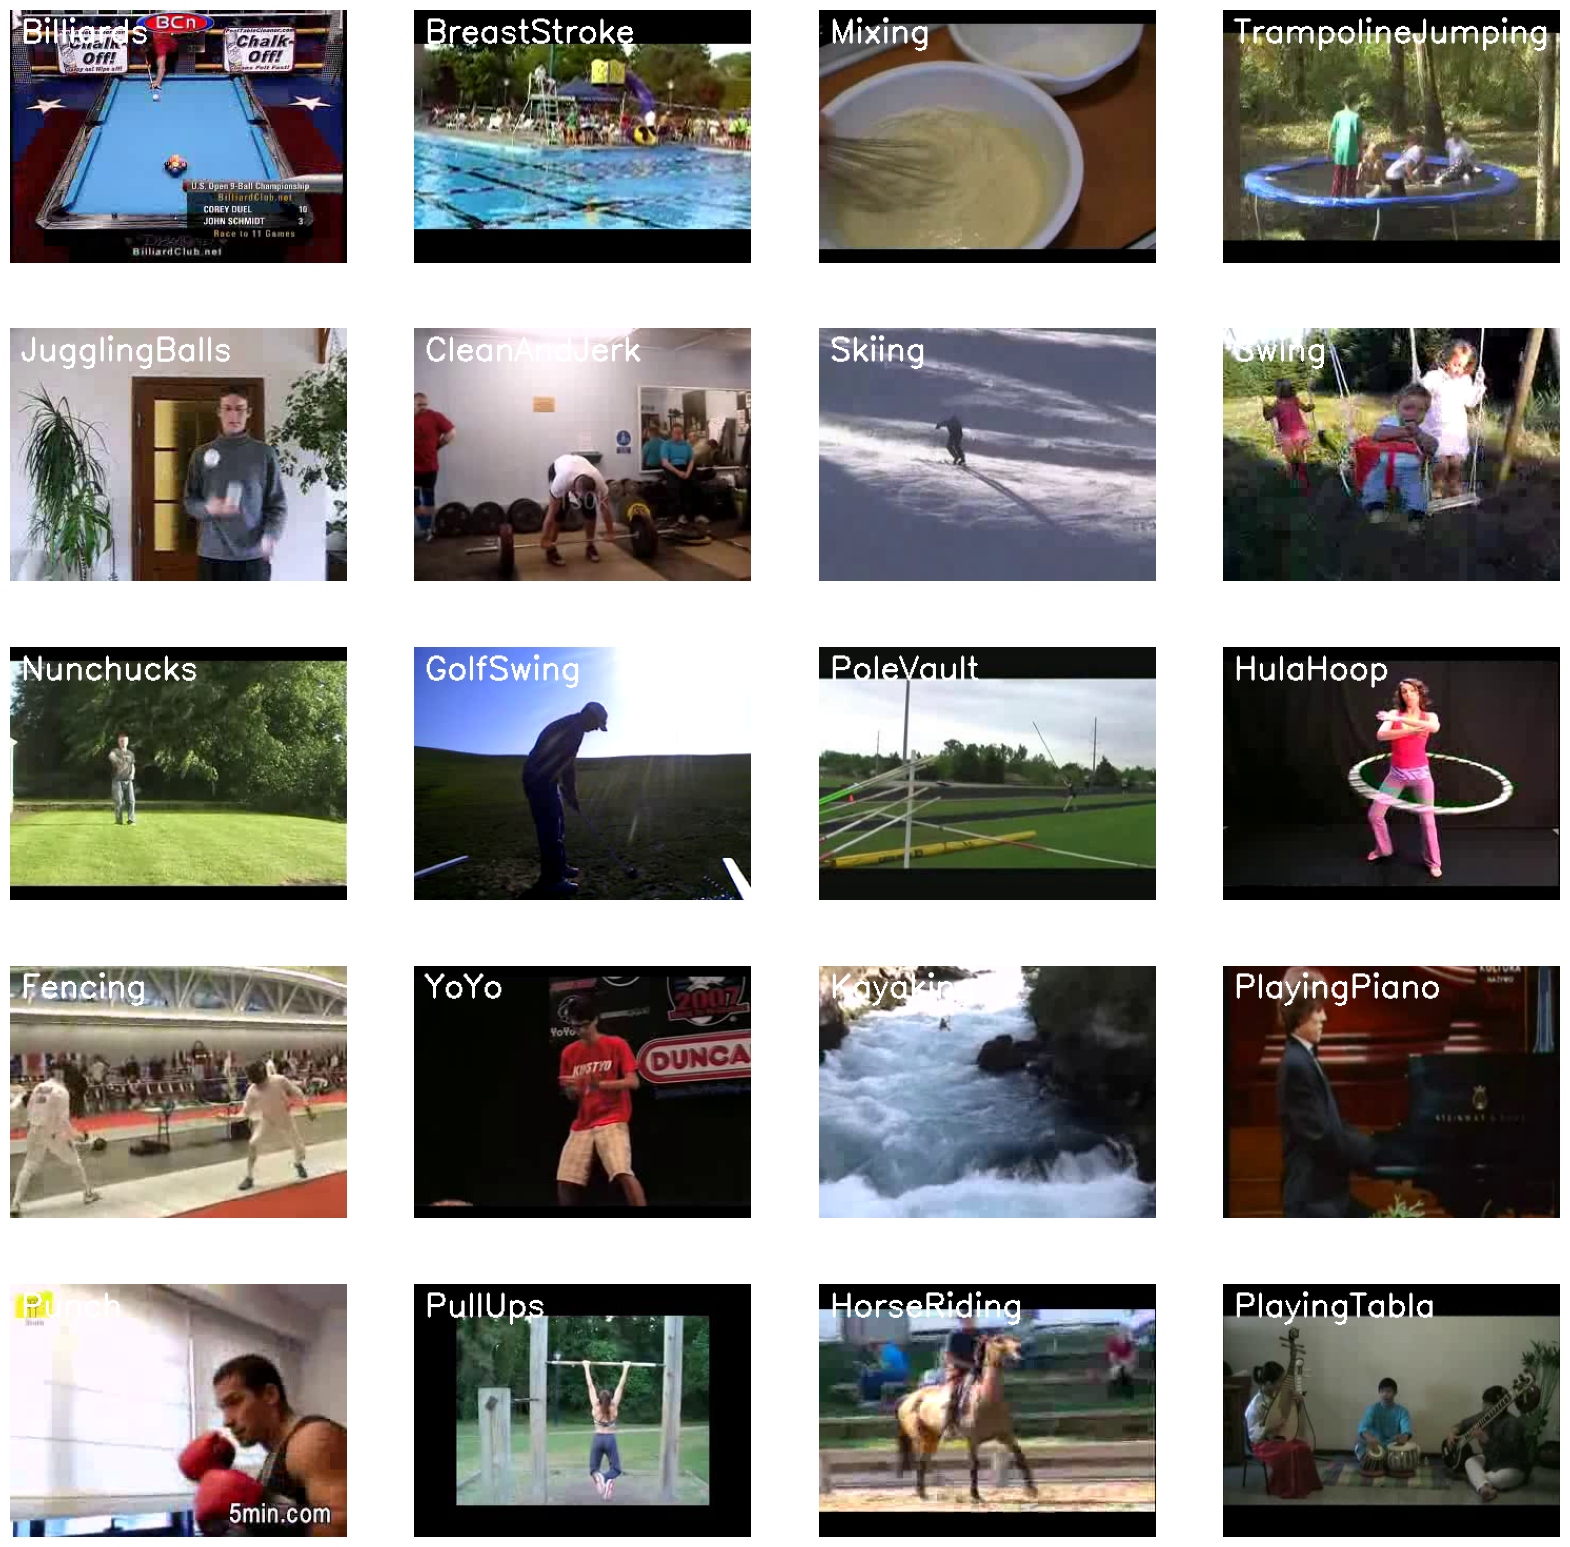

In [8]:
# Visualizing 20 random action cateogry

plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values.
# The values will be between 0-50, where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

**STEP 2: PREPROCESSING DATASET**

In [9]:
# Specify the height and width to which each video frame will be resized
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence
SEQUENCE_LENGTH = 20

# Specify the dataset directory
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training
# For this project 6 out 50 activity is selected
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace", "PushUps", "Rowing"]

In [10]:
# Create a Function to Extract, Resize & Normalize Frames
def frames_extraction(video_path):
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object
    video_reader.release()

    return frames_list

In [11]:
# Create a Function for Dataset Creation
def create_dataset():
    # Declared Empty Lists to store the features(frames), labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [12]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: PushUps
Extracting Data of Class: Rowing


In [13]:
# Convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)
print(one_hot_encoded_labels)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


**STEP 3: SPLITTING DATASET INTO TRAIN AND TEST**

In [14]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

print(features_train.shape, features_test.shape, labels_train.shape, labels_test.shape)

(547, 20, 64, 64, 3) (183, 20, 64, 64, 3) (547, 6) (183, 6)


**STEP 4: IMPLEMENT THE ConvLSTM APPROACH**

In [15]:
def create_convlstm_model():
    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    # Display the models summary.
    model.summary()

    return model

In [16]:
# Construct the required model
convlstm_model = create_convlstm_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                        

In [17]:
# Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compiling
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Training
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
110/110 [==============================] - 56s 424ms/step - loss: 1.8005 - accuracy: 0.1739 - val_loss: 1.7864 - val_accuracy: 0.2182
Epoch 2/50
110/110 [==============================] - 46s 418ms/step - loss: 1.7736 - accuracy: 0.2609 - val_loss: 1.6803 - val_accuracy: 0.2545
Epoch 3/50
110/110 [==============================] - 45s 406ms/step - loss: 1.5589 - accuracy: 0.3890 - val_loss: 1.4130 - val_accuracy: 0.5091
Epoch 4/50
110/110 [==============================] - 45s 411ms/step - loss: 1.2187 - accuracy: 0.5355 - val_loss: 1.3483 - val_accuracy: 0.4727
Epoch 5/50
110/110 [==============================] - 46s 416ms/step - loss: 0.9428 - accuracy: 0.6590 - val_loss: 1.1202 - val_accuracy: 0.5455
Epoch 6/50
110/110 [==============================] - 46s 420ms/step - loss: 0.6950 - accuracy: 0.7346 - val_loss: 1.0074 - val_accuracy: 0.6364
Epoch 7/50
110/110 [==============================] - 45s 414ms/step - loss: 0.5819 - accuracy: 0.7849 - val_loss: 1.3181 - val_ac

In [18]:
# Evaluating
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

6/6 [==============================] - 1s 227ms/step - loss: 0.8061 - accuracy: 0.7432


In [19]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Save your Model.
convlstm_model.save('convlstm_model.h5')

  saving_api.save_model(



In [20]:
# function will plot the metrics passed to it in a graph
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))
    plt.legend()

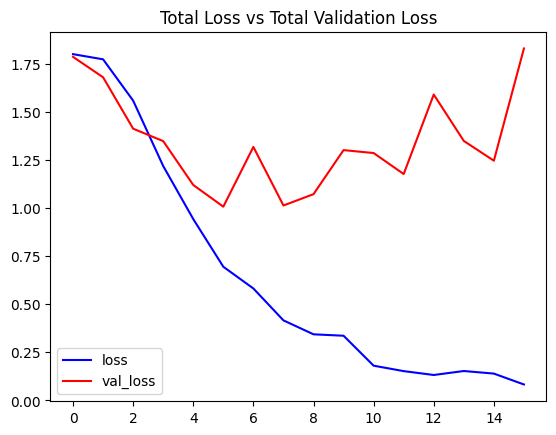

In [21]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

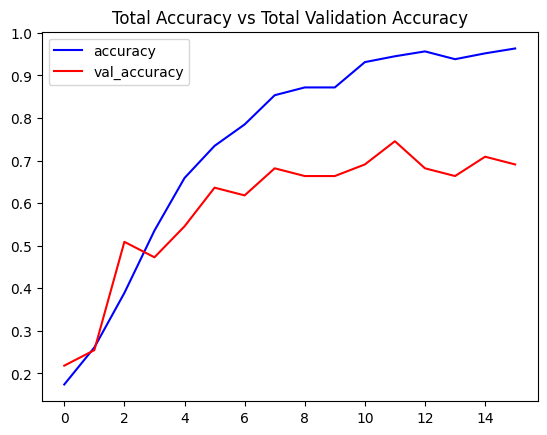

In [22]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

**STEP 5: CONSTRUCT THE MODEL FOR LRCN**

In [23]:
def create_LRCN_model():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    # Display the models summary.
    model.summary()

    return model

In [24]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 20, 64, 64, 16)    448       
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 20, 4, 4, 32)     

In [25]:
# Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compiling
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Training
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
110/110 [==============================] - 6s 36ms/step - loss: 1.8029 - accuracy: 0.1899 - val_loss: 1.7900 - val_accuracy: 0.1727
Epoch 2/70
110/110 [==============================] - 3s 28ms/step - loss: 1.6739 - accuracy: 0.3112 - val_loss: 1.6439 - val_accuracy: 0.3000
Epoch 3/70
110/110 [==============================] - 3s 29ms/step - loss: 1.5970 - accuracy: 0.3341 - val_loss: 1.7128 - val_accuracy: 0.2909
Epoch 4/70
110/110 [==============================] - 3s 28ms/step - loss: 1.4993 - accuracy: 0.3936 - val_loss: 1.6234 - val_accuracy: 0.2909
Epoch 5/70
110/110 [==============================] - 3s 28ms/step - loss: 1.3787 - accuracy: 0.4805 - val_loss: 2.0123 - val_accuracy: 0.2364
Epoch 6/70
110/110 [==============================] - 3s 28ms/step - loss: 1.1818 - accuracy: 0.5515 - val_loss: 1.1520 - val_accuracy: 0.5636
Epoch 7/70
110/110 [==============================] - 3s 28ms/step - loss: 1.0924 - accuracy: 0.5858 - val_loss: 1.1411 - val_accuracy: 0.5364

In [26]:
# Evaluating
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

6/6 [==============================] - 0s 40ms/step - loss: 0.3843 - accuracy: 0.9126


In [28]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Save the Model.
LRCN_model.save('LRCN_model.h5')

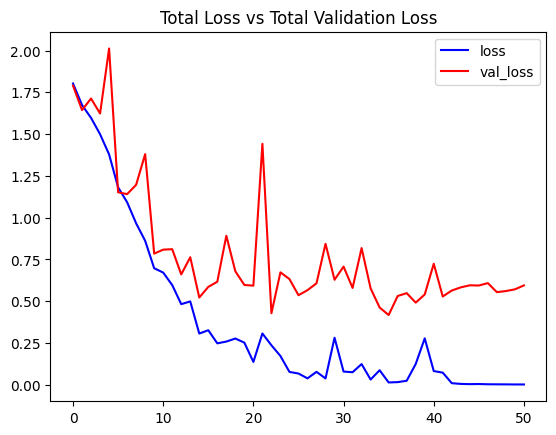

In [29]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

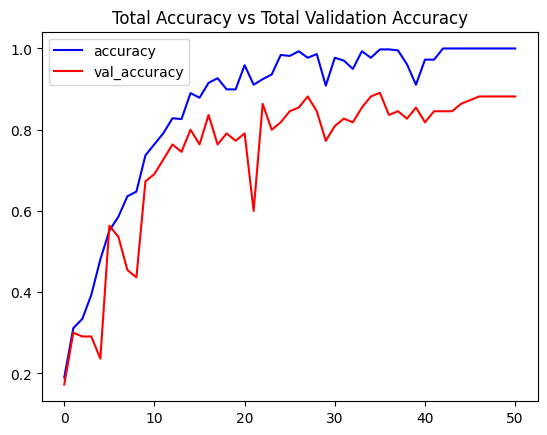

In [30]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')